**Cell 1: Setup & Device Selection**

	•	Imported necessary PyTorch, Torchvision, and utility libraries.
	•	Checked if CUDA (GPU) is available and set the device accordingly.
	•	Ensured all computations run efficiently on either CPU or GPU.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Cell 2: Data Preprocessing & Loading**

	•	Applied data augmentation on the CIFAR-10 training dataset:
	•	Random horizontal flips, random cropping, color jittering for better generalization.
	•	CutMix & MixUp applied to create blended images, improving model robustness.
	•	Normalized images to the standard range.
	•	Split CIFAR-10 dataset into training (80%) and validation (20%) while maintaining class balance.
	•	Created DataLoaders for efficient batch processing.

In [2]:
import torch
from torch.utils.data import Subset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchvision.transforms.v2 import CutMix, MixUp  

# Define Training Transform 
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

# Apply CutMix and MixUp during training
cutmix = CutMix(num_classes=10, alpha=1.5)
mixup = MixUp(num_classes=10, alpha=0.4)

# Define Validation Transform (No augmentations, just normalization)
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Only normalize
])

# Load CIFAR-10 Dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split CIFAR-10 into train and validation indices (stratify for class balance)
train_indices, val_indices = train_test_split(
    range(len(full_trainset)), test_size=0.2, random_state=42, stratify=full_trainset.targets
)

# Create training and validation subsets with respective transforms
train_subset = Subset(full_trainset, train_indices)

# Create a validation dataset with a different transform
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_val)
val_subset = Subset(val_dataset, val_indices)

# Define DataLoaders
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

print(f"Training Samples: {len(train_subset)}, Validation Samples: {len(val_subset)}")

100%|██████████| 170M/170M [00:03<00:00, 56.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Samples: 40000, Validation Samples: 10000


**Cell 3: Custom Test Dataset Handling**

	•	Loaded test images (CIFAR-10 without labels) from a .pkl file.
	•	Implemented a CustomTestDataset class:
	•	Converts raw pixel data into PIL images.
	•	Applies transformations and returns image IDs.
	•	Created a DataLoader to efficiently process test images in batches.

In [3]:
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Load Test Dataset
file_path = "/kaggle/input/data-final/cifar_test_nolabel.pkl"

with open(file_path, 'rb') as f:
    data_dict = pickle.load(f, encoding="bytes")

# Extract Data
raw_images = np.array(data_dict[b'data'], dtype=np.uint8)  
image_ids = np.array(data_dict[b'ids'], dtype=np.int64)

# Custom Dataset Class 
class CustomTestDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, 'rb') as f:
            data_dict = pickle.load(f, encoding='bytes')

        self.images = np.array(data_dict[b'data'], dtype=np.uint8)  
        self.image_ids = torch.tensor(data_dict[b'ids'], dtype=torch.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.fromarray(self.images[index])  
        img_id = int(self.image_ids[index])

        if self.transform:
            img = self.transform(img)  

        return img, img_id

# Define Standard CIFAR-10 Transform 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load Custom Test Dataset 
custom_testset = CustomTestDataset(file_path, transform=transform_test)
custom_test_loader = DataLoader(custom_testset, batch_size=128, shuffle=False, num_workers=0)

**Cell 4: ResNet-18 Model with Custom Modifications**

	•	Built a modified ResNet-18 for CIFAR-10 classification.
	•	Changes made:
	•	Replaced initial conv layer with a 3×3 convolution (better for small images).
	•	Increased initial channels to 48.
	•	Used Bottleneck Blocks for efficient feature extraction:
	•	1x1 convolution reduces channels → 3x3 convolution processes → 1x1 expands back.
	•	Used SiLU activation (better than ReLU in some cases).
	•	Used Batch Normalization for stable training.
	•	Adaptive Average Pooling ensures compatibility with different image sizes.
	•	Defined a lightweight fully connected layer with dropout to prevent overfitting.
	•	Ensured model trainable parameters < 5 million.

In [4]:
import torchvision.models as models
import torch.nn as nn
import torch

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        # Load ResNet-18 
        self.model = models.resnet18(weights=None)

        # Convolution Filters 
        self.model.conv1 = nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.bn1 = nn.BatchNorm2d(48)  

        # Use Optimized Bottleneck Blocks (Instead of Standard Residual Blocks)
        def bottleneck_block(in_channels, out_channels, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, bias=False),  
                nn.BatchNorm2d(in_channels // 2),  
                nn.SiLU(),
                nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(in_channels // 2), 
                nn.SiLU(),
                nn.Conv2d(in_channels // 2, out_channels, kernel_size=1, bias=False),  
                nn.BatchNorm2d(out_channels),  
                nn.SiLU(),
            )

        # ResNet Blocks to Reduce Parameters
        self.model.layer1 = nn.Sequential(bottleneck_block(48, 96), bottleneck_block(96, 96))
        self.model.layer2 = nn.Sequential(bottleneck_block(96, 192, stride=2), bottleneck_block(192, 192))
        self.model.layer3 = nn.Sequential(bottleneck_block(192, 384, stride=2), bottleneck_block(384, 384))
        self.model.layer4 = nn.Sequential(bottleneck_block(384, 768, stride=2), bottleneck_block(768, 768))

        # Adaptive Pooling for Compact Representation
        self.model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer
        self.model.fc = nn.Sequential(
            nn.Linear(768, 384),
            nn.SiLU(),
            nn.Dropout(0.3),  # Increased Dropout for Regularization
            nn.Linear(384, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize Model & Move to Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

# Print Model Parameters to Ensure it's below 5M
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {param_count}")

Total Trainable Parameters: 3590938


**Cell 5: Model Training Setup**

	•	Optimizer: Used SGD with momentum, weight decay, and Nesterov acceleration for efficient training.
	•	Learning Rate Scheduler: OneCycleLR dynamically adjusts learning rates.
	•	Loss Function: Cross-Entropy with label smoothing (0.15) for better generalization.
	•	Automatic Mixed Precision (AMP): Speeds up training and reduces memory usage.
	•	Gradient Clipping: Prevents exploding gradients.
	•	Defined training and validation functions:
	•	Training loop updates weights and logs progress every 100 batches.
	•	Validation function evaluates model on the validation dataset.
	•	Saves best model based on validation accuracy.

In [5]:
import torch.optim as optim
import torch.nn as nn
import torch.amp as amp  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
model = ResNet18(num_classes=10).to(device)

# Optimized Optimizer - SGD with Momentum & Lower Weight Decay
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Learning Rate Scheduler - OneCycleLR for Better Convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.03,  
    epochs=170, 
    steps_per_epoch=len(train_loader),
    pct_start=0.3  
)

# Define Loss Function with Label Smoothing (Better Regularization)
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)  

# Enable Automatic Mixed Precision (AMP) for Faster Training
scaler = torch.amp.GradScaler()  

best_val_acc = 0

def validate(model, val_loader, criterion):
    """Function to Evaluate Model on Validation Set"""
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    avg_val_loss = val_loss / len(val_loader)
    print(f"[Validation] Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    
    return avg_val_loss, val_acc

def train(model, train_loader, val_loader, optimizer, criterion, epoch):
    """Function to Train Model on Training Set"""
    global best_val_acc  
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):  
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Mixed Precision Backpropagation
        scaler.scale(loss).backward()

        # Gradient Clipping (Prevents Exploding Gradients)
        scaler.unscale_(optimizer)  
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  

        # Optimizer Step & Update AMP Scaler
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  

        # Track Loss & Accuracy
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print Training Progress Every 100 Batches
        if batch_idx % 100 == 0:
            print(f"[Epoch {epoch} - Batch {batch_idx}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f}, Acc: {100. * correct / total:.2f}%")

    train_acc = 100. * correct / total
    avg_train_loss = total_loss / len(train_loader)
    print(f"Final [Epoch {epoch} Completed] Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Perform Validation After Each Epoch
    avg_val_loss, val_acc = validate(model, val_loader, criterion)

    # Save Best Model If Validation Accuracy Improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model updated with Validation Accuracy: {best_val_acc:.2f}%")

    return avg_train_loss, train_acc, avg_val_loss, val_acc


**Cell 6: Training Loop & Visualization**

	•	Trains the model for 170 epochs.
	•	Logs:
	•	Learning rate updates at the start of each epoch.
	•	Loss & accuracy updates every 100 batches.
	•	Saves:
	•	Best model whenever validation accuracy improves.
	•	Checkpoint every 5 epochs to prevent data loss.
	•	Plots training vs validation loss and accuracy curves after training.


Starting Epoch 1/170...
Initial LR: 0.001200
Batch 0/313 - Loss: 2.3076, Acc: 7.81%, LR: 0.001200
Batch 100/313 - Loss: 2.3142, Acc: 11.29%, LR: 0.001203
Batch 200/313 - Loss: 2.2915, Acc: 11.94%, LR: 0.001211
Batch 300/313 - Loss: 2.2682, Acc: 12.53%, LR: 0.001225
Epoch [1/170] - Loss: 2.2836, Accuracy: 12.60%
[Validation] Loss: 2.2765, Accuracy: 13.06%
Best model updated! Validation Accuracy: 13.06%

Starting Epoch 2/170...
Initial LR: 0.001227
Batch 0/313 - Loss: 2.2609, Acc: 13.28%, LR: 0.001227
Batch 100/313 - Loss: 2.2406, Acc: 15.77%, LR: 0.001248
Batch 200/313 - Loss: 2.1891, Acc: 16.77%, LR: 0.001274
Batch 300/313 - Loss: 2.1127, Acc: 17.81%, LR: 0.001305
Epoch [2/170] - Loss: 2.1954, Accuracy: 17.94%
[Validation] Loss: 2.0983, Accuracy: 21.47%
Best model updated! Validation Accuracy: 21.47%

Starting Epoch 3/170...
Initial LR: 0.001309
Batch 0/313 - Loss: 2.0925, Acc: 20.31%, LR: 0.001310
Batch 100/313 - Loss: 2.0910, Acc: 21.60%, LR: 0.001347
Batch 200/313 - Loss: 2.0508, A

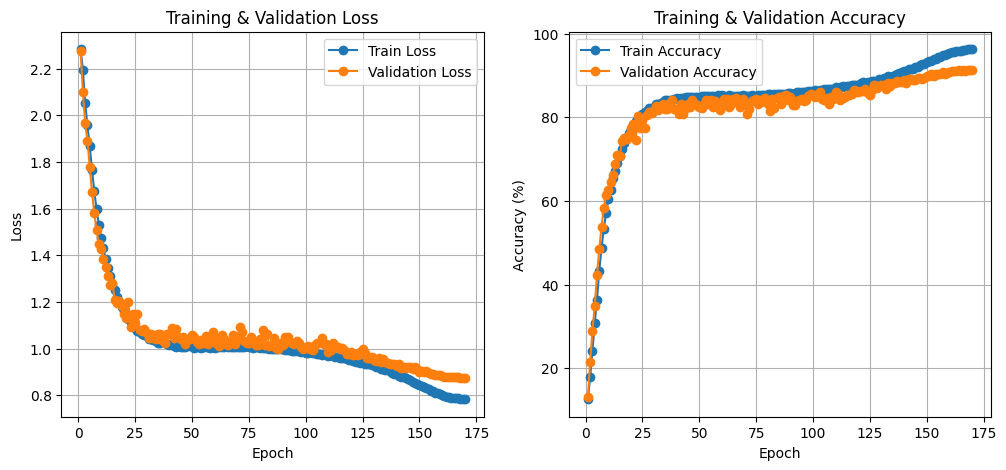

In [6]:
import random
import matplotlib.pyplot as plt

num_epochs = 170  
best_val_acc = 0  

# Lists to store training history for visualization
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}...")

    try:
        model.train()
        total_loss, correct, total = 0, 0, 0

        # Print Learning Rate at Start of Each Epoch
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Initial LR: {current_lr:.6f}")

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed Precision Training
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):  
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward Pass with AMP Scaling
            scaler.scale(loss).backward()

            # Gradient Clipping to Prevent Exploding Gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Step Optimizer & AMP Update
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  

            # Track Loss & Accuracy
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Print updated LR every 100 batches
            if batch_idx % 100 == 0:
                updated_lr = optimizer.param_groups[0]["lr"]
                print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}, "
                      f"Acc: {100. * correct / total:.2f}%, LR: {updated_lr:.6f}")

        # Compute Epoch Metrics
        train_acc = 100. * correct / total
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Perform Validation After Each Epoch
        avg_val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        # Save Best Model Based on Validation Accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc
            }, f"best_model_{best_val_acc:.2f}.pth")
            print(f"Best model updated! Validation Accuracy: {best_val_acc:.2f}%")

        # Save Checkpoint Every 5 Epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch+1}.pth")


        # Step the Scheduler AFTER Validation (for schedulers like ReduceLROnPlateau)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)  # Pass validation loss
        elif not isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()  # For StepLR, MultiStepLR, CosineAnnealingLR

    except Exception as e:
        print(f"❌ Error in Epoch {epoch+1}: {e}")
        continue  # Skip to next epoch instead of stopping training

# Plot Training Curves After Training
plt.figure(figsize=(12, 5))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

**Cell 7: Saving the Trained Model**

	•	Saves the trained model’s state dictionary (best_model.pth).
	•	Ensures the best-performing model is preserved.

In [7]:
torch.save(model.state_dict(), "best_model.pth")
print("Model saved successfully!")

Model saved successfully!


**Cell 8: Loading the Trained Model for Testing**

	•	Loads the saved model checkpoint.
	•	Moves the model to GPU (if available).
	•	Switches the model to evaluation mode for inference.
	•	Ensures reproducibility before making test predictions.

In [8]:
# Load the trained model
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.to(device)
model.eval()  
print("Model loaded for testing!")

Model loaded for testing!


**Cell 9: Running Predictions on Test Data**

	•	Turns off gradient tracking (torch.no_grad()) to speed up inference.
	•	Loops through test dataset in batches:
	•	Moves images to GPU.
	•	Computes model outputs.
	•	Retrieves class predictions using torch.max().
	•	Stores predictions as (image ID, predicted class) pairs.
	•	Confirms that test predictions are completed.

In [9]:
predictions = []

with torch.no_grad():  # Disable gradient tracking for faster inference
    for images, img_ids in custom_test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        predictions.extend(zip(img_ids.cpu().numpy(), predicted.cpu().numpy()))

print(f"Test Predictions Done! Total Images: {len(predictions)}")

Test Predictions Done! Total Images: 10000


**Cell 10: Visualizing Predictions**

	•	Runs inference on the test set and collects:
	•	Predicted labels.
	•	Corresponding image IDs.
	•	Test images for visualization.
	•	Displays first 100 test images in a 10×10 grid:
	•	Converts tensor images to NumPy format.
	•	Clips pixel values for proper visualization.
	•	Shows predicted class and image ID as titles.

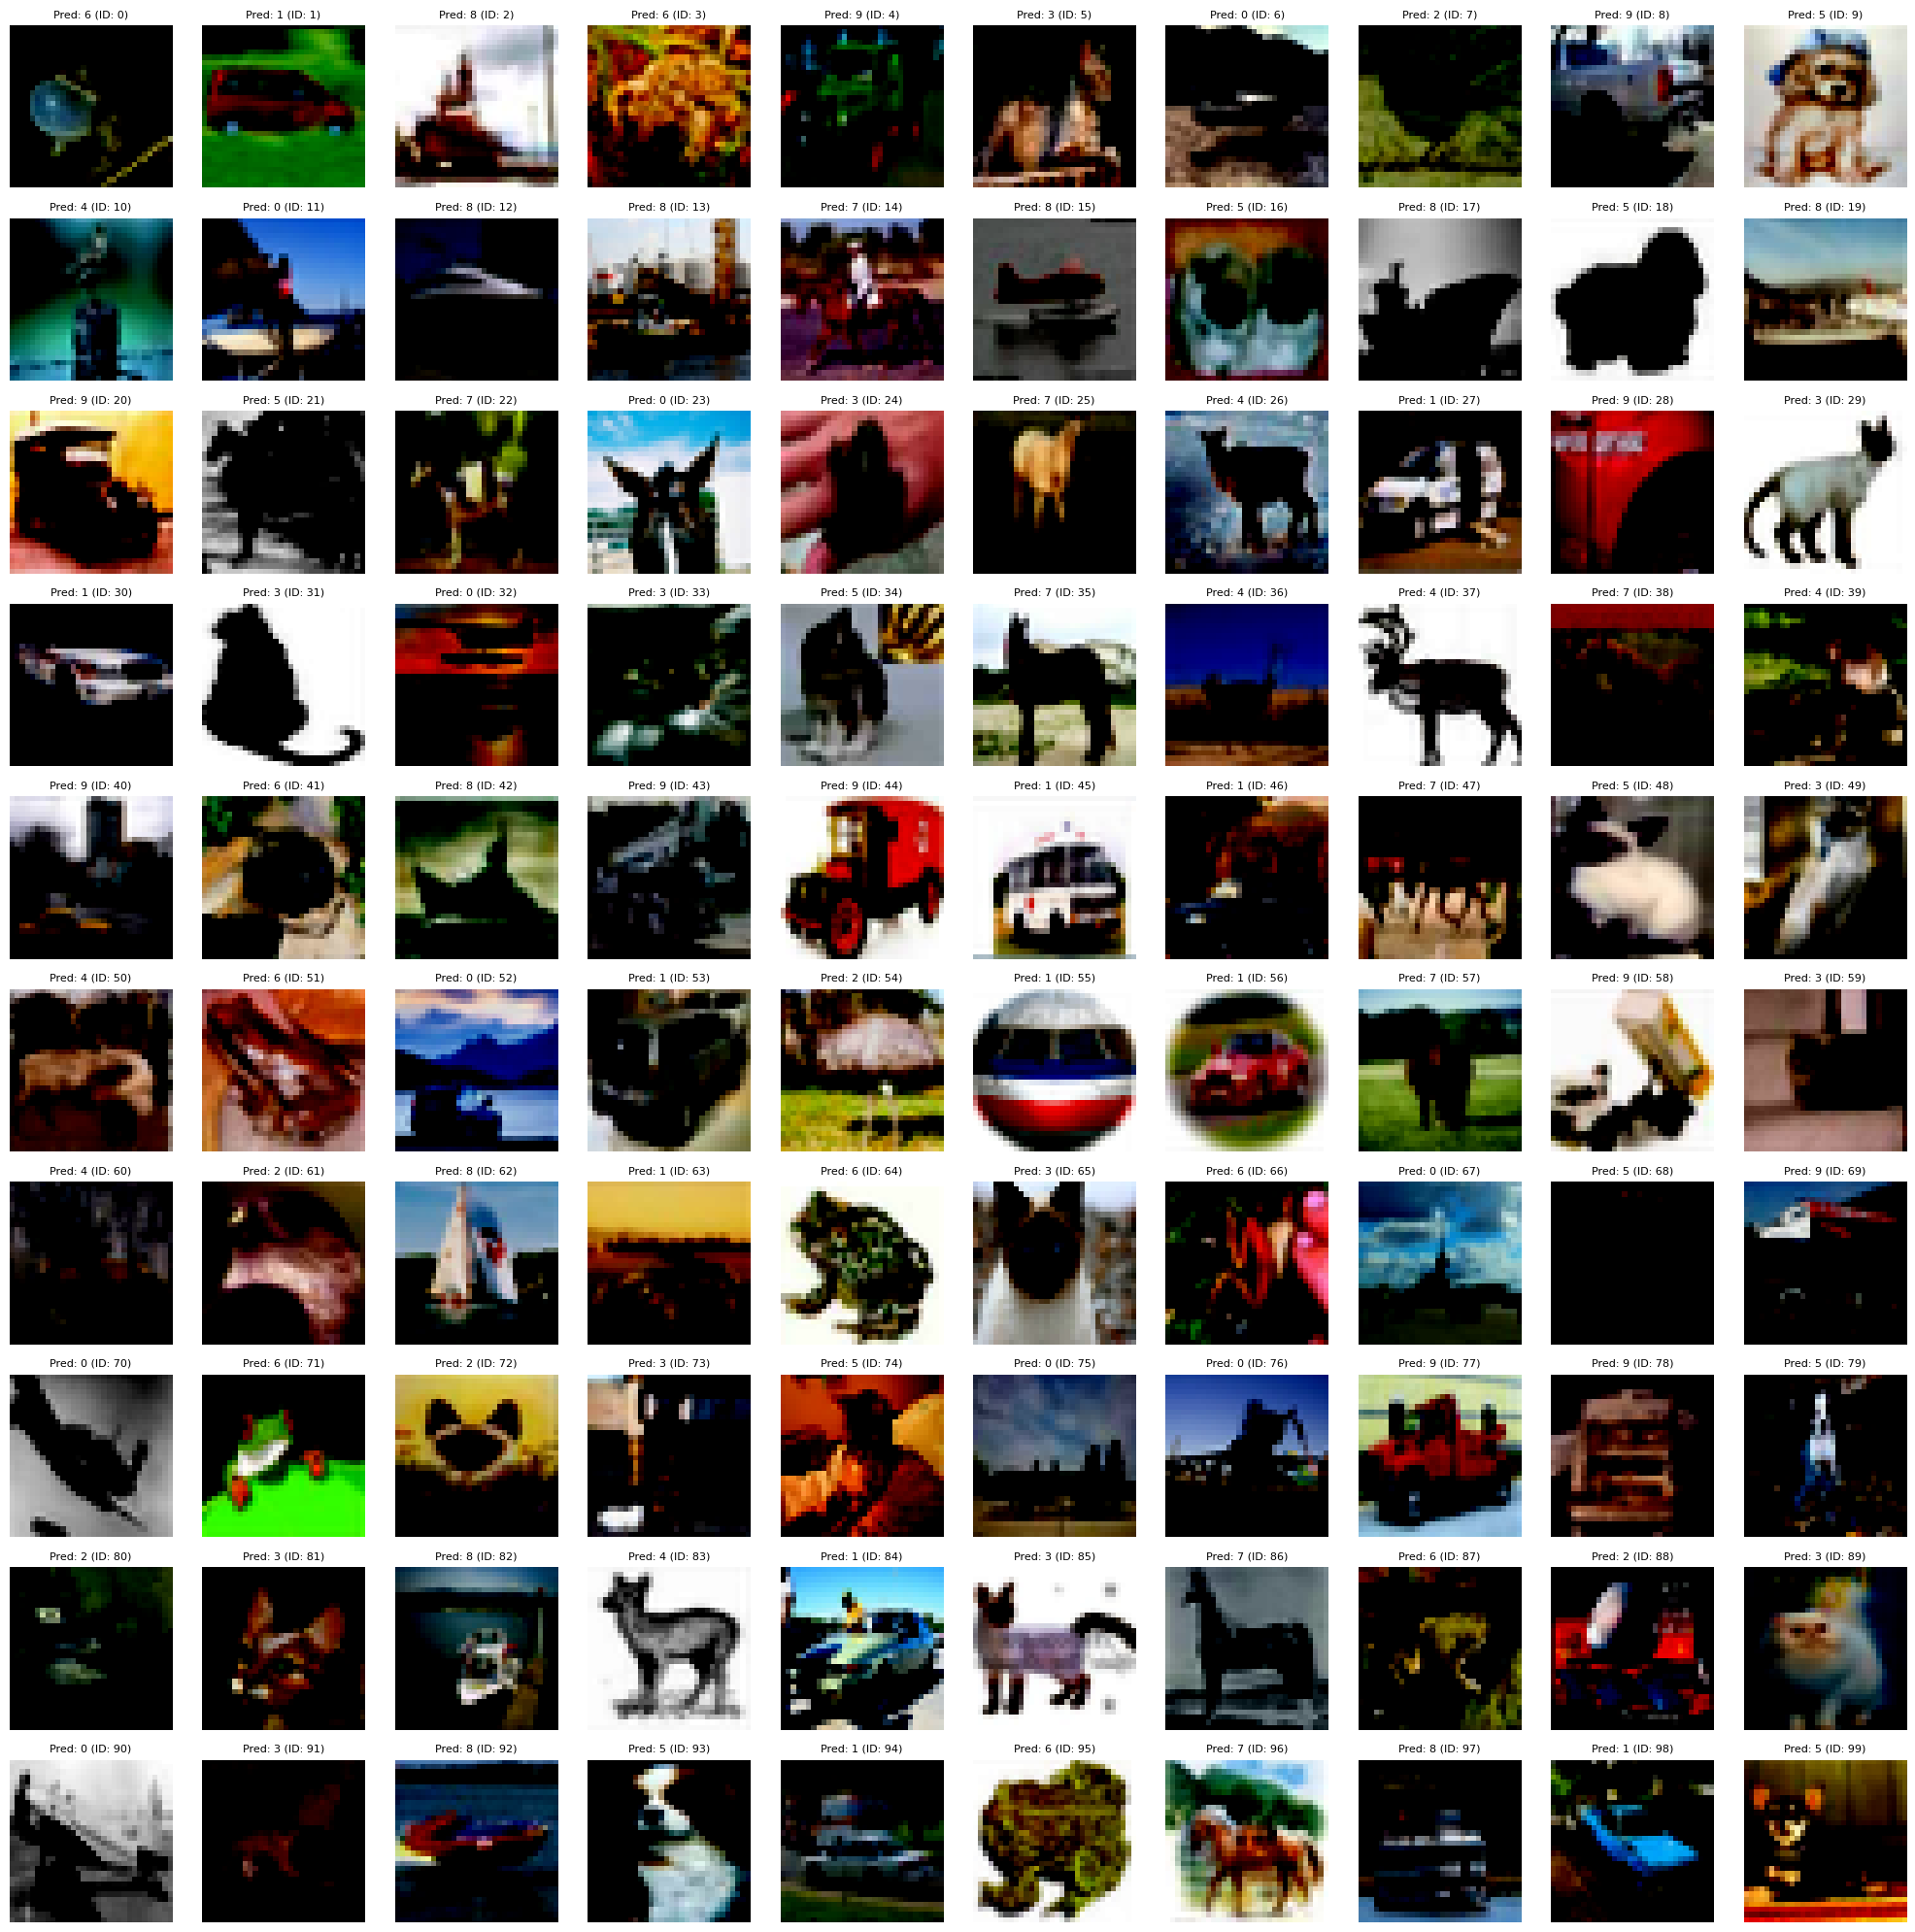

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Run inference on test data
predicted_labels = []
img_ids = []
test_images = []  # Store images for visualization

with torch.no_grad():  
    for images, ids in custom_test_loader:
        images = images.to(device)  
        outputs = model(images)
        preds = outputs.argmax(dim=1) 
        
        predicted_labels.extend(preds.cpu().tolist())
        img_ids.extend(ids.cpu().tolist())  
        test_images.extend(images.cpu().numpy())  

# Display Predictions for First 100 Images
fig, axes = plt.subplots(10, 10, figsize=(20, 20))  

for i, ax in enumerate(axes.flat[:100]): 
    img = test_images[i].transpose(1, 2, 0)
    
    img = np.clip(img, 0, 1) 

    ax.imshow(img)
    ax.set_title(f"Pred: {predicted_labels[i]} (ID: {img_ids[i]})", fontsize=8)  
    ax.axis("off")

plt.tight_layout()
plt.show()

**Cell 11: Generating Submission File**

	•	Runs final inference on test images.
	•	Computes softmax probabilities for predictions.
	•	Stores (image ID, predicted label) pairs in a Pandas DataFrame.
	•	Sorts data by image ID for consistency.
	•	Saves the predictions in a CSV file (submission.csv).
	•	Prints confirmation that the submission file was successfully created.

In [11]:
import pandas as pd

def generate_submission(model, custom_test_loader, filename="submission.csv"):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, img_ids in custom_test_loader:
            images = images.to(device)
            outputs = model(images)

            # Compute softmax probabilities
            probs = torch.softmax(outputs, dim=1)
            top_probs, predicted = probs.max(1)  
            predictions.extend(zip(img_ids.cpu().numpy(), predicted.cpu().numpy()))

    #  Convert predictions into DataFrame & Save
    df = pd.DataFrame(predictions, columns=["ID", "Labels"]).sort_values(by="ID")
    df.to_csv(filename, index=False)
    print(f"Submission file '{filename}' generated successfully!")

generate_submission(model, custom_test_loader)

Submission file 'submission.csv' generated successfully!


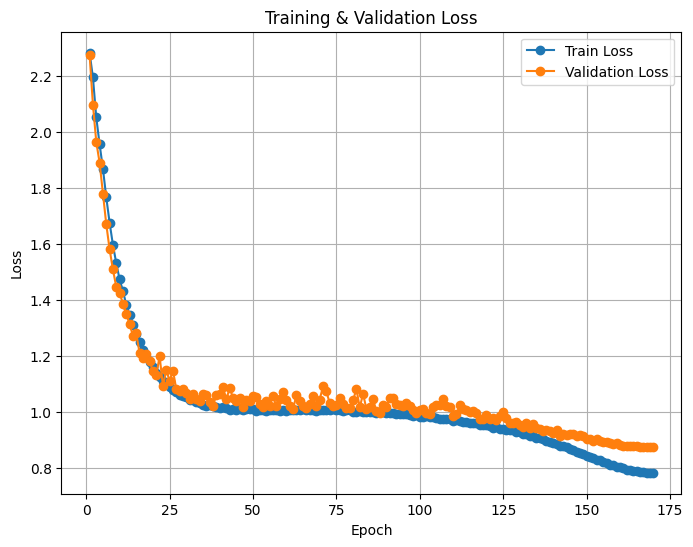

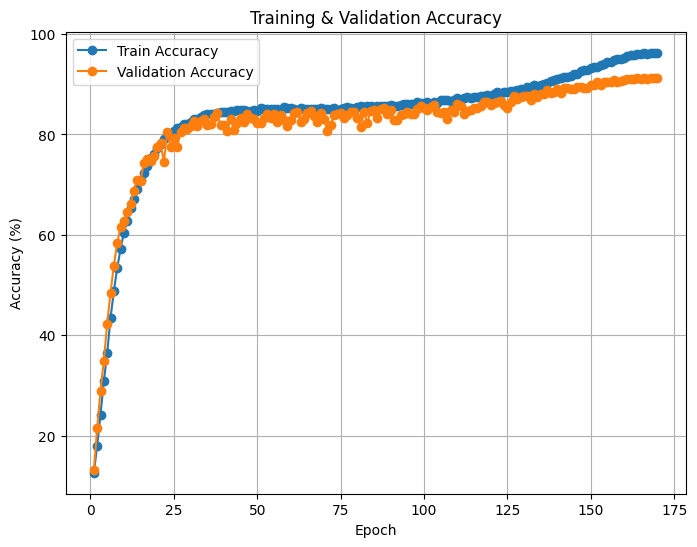

Plots saved successfully! You can download them from the 'Output' section.


In [14]:
import matplotlib.pyplot as plt

# Save Loss Curve as a Separate Image
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("/kaggle/working/loss_curve.png", dpi=300, bbox_inches="tight")  # Save loss curve
plt.show()

# Save Accuracy Curve as a Separate Image
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("/kaggle/working/accuracy_curve.png", dpi=300, bbox_inches="tight")  # Save accuracy curve
plt.show()

print("Plots saved successfully! You can download them from the 'Output' section.")